In [27]:
%load_ext autoreload
%autoreload 2
import sys
import os
notebook_dir = os.path.dirname(os.path.abspath(''))
if notebook_dir not in sys.path:
    sys.path.append(os.path.dirname(notebook_dir))
from notebooks.config import *
configure_matplotlib()
SAVE_FIGURES = True
fig_path = RETROSEQ_FIGURE_DIR
from functools import partial
save_figure = partial(save_figure, dir_path=fig_path)
cpm_scl = CPM_SCL

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys
import scanpy as sc
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import processing, utils, plotting, heatmap
import pseudoclusters, test_structures
print(f"scanpy version: {sc.__version__}")
print(f"scvi version: {scvi.__version__}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy version: 1.11.3
scvi version: 1.3.3


In [29]:
savefilename = RETROSEQ_DATA_DIR+"/retro_BN_d4_1500genes.h5ad"
savefilename = RETROSEQ_DATA_DIR+"/retroseq_updated_filtered.h5ad"
adata_retro = sc.read_h5ad(savefilename)
adata_retro = adata_retro[adata_retro.obs['injection_site'].notna(), :]
adata_retro.shape

(567, 1500)

In [69]:
adata_retro.X.max()

7824.0

In [59]:
from sklearn.preprocessing import LabelEncoder
# X = adata_retro.layers['BN']
X = np.array(adata_retro.X.toarray())
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

le = LabelEncoder()
y = le.fit_transform(adata_retro.obs['injection_site'])


In [60]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.40,
    stratify=y,
    random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,     # half of 40% → 20% each
    stratify=y_temp,
    random_state=42
)


In [61]:
# Prepare X/Y lists for convenience
X_list = [X_train, X_val, X_test]
y_list = [y_train, y_val, y_test]


In [62]:
# Define a helper to train, validate, and test
def fit_and_report(name, X_list, y_list, model, param_grid=None, scale=False):
    X_tr, X_val_, X_te = X_list
    y_tr, y_val_, y_te = y_list
    steps = []
    if scale:
        steps.append(('scaler', StandardScaler()))
    steps.append(('clf', model))
    pipe = Pipeline(steps)
    # Hyperparameter tuning if grid given
    if param_grid is not None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        grid = GridSearchCV(pipe, param_grid, cv=cv, n_jobs=-1, scoring='accuracy')
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_
        print(f"{name} best params: {grid.best_params_}")
    else:
        best = pipe.fit(X_tr, y_tr)
    # Validation
    y_val_pred = best.predict(X_val_)
    val_acc = accuracy_score(y_val_, y_val_pred)
    print(f"[{name}] Val Accuracy: {val_acc:.4f}")
    # Retrain on train+val then test
    best.fit(np.vstack([X_tr, X_val_]), np.concatenate([y_tr, y_val_]))
    y_test_pred = best.predict(X_te)
    test_acc = accuracy_score(y_te, y_test_pred)
    print(f"[{name}] Test Accuracy: {test_acc:.4f}\n")
    return name, best, val_acc, test_acc, y_test_pred


In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Extend your models dict:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest':        RandomForestClassifier(),
    'SVC':                 SVC(),
    'KNN':                 KNeighborsClassifier(),
    'GradBoost':           GradientBoostingClassifier(),
    # 'XGBoost':             XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# And their parameter grids:
param_grids = {
    'LogisticRegression': {'clf__C': [0.01, 0.1, 1, 10]},
    'RandomForest':       {'clf__n_estimators': [100, 200], 'clf__max_depth': [None, 10, 20]},
    'SVC':                {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']},
    'KNN':                {'clf__n_neighbors': [3, 5, 7]},
    'GradBoost':          {
        'clf__n_estimators': [100, 200],
        'clf__learning_rate':[0.01, 0.1],
        'clf__max_depth':    [3, 5]
    },
    # 'XGBoost':            {
    #     'clf__n_estimators': [100, 200],
    #     'clf__learning_rate':[0.01, 0.1],
    #     'clf__max_depth':    [3, 5]
    # }
}

results = []
for name, model in models.items():
    print(f"Running {name}...")
    pg = param_grids.get(name)
    m_name, best, val_acc, test_acc, y_pred = fit_and_report(
        name, X_list, y_list, model, pg, scale=True
    )
    results.append({
        'model':    m_name,
        'val_acc':  val_acc,
        'test_acc': test_acc,
        'best':     best,
        'y_pred':   y_pred
    })

results_df = pd.DataFrame(results)[['model','val_acc','test_acc']]
display(results_df)

Running LogisticRegression...
LogisticRegression best params: {'clf__C': 0.01}
[LogisticRegression] Val Accuracy: 0.4956
[LogisticRegression] Test Accuracy: 0.5877

Running RandomForest...
RandomForest best params: {'clf__max_depth': None, 'clf__n_estimators': 200}
[RandomForest] Val Accuracy: 0.6106
[RandomForest] Test Accuracy: 0.6579

Running SVC...
SVC best params: {'clf__C': 0.1, 'clf__kernel': 'linear'}
[SVC] Val Accuracy: 0.4602
[SVC] Test Accuracy: 0.5614

Running KNN...
KNN best params: {'clf__n_neighbors': 7}
[KNN] Val Accuracy: 0.3274
[KNN] Test Accuracy: 0.3333

Running GradBoost...
GradBoost best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 3, 'clf__n_estimators': 200}
[GradBoost] Val Accuracy: 0.6726
[GradBoost] Test Accuracy: 0.6228



,model,val_acc,test_acc
0,LogisticRegression,0.495575,0.587719
1,RandomForest,0.610619,0.657895
2,SVC,0.460177,0.561404
3,KNN,0.327434,0.333333
4,GradBoost,0.672566,0.622807


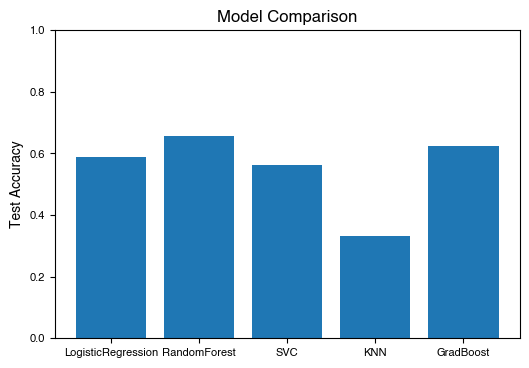

In [64]:
plt.figure(figsize=(6,4))
plt.bar(results_df['model'], results_df['test_acc'])
plt.ylim(0,1)
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.show()


# classification report for the best model 

In [65]:
best_idx = np.argmax([r['test_acc'] for r in results])
best_row = results[best_idx]
print(f"Best model: {best_row['model']}")
print(classification_report(y_test, best_row['y_pred'], target_names=le.classes_))


Best model: RandomForest
                precision    recall  f1-score   support

    Cerebellum       0.55      0.79      0.65        42
Frontal Cortex       0.75      0.34      0.47        35
   Spinal Cord       0.79      0.81      0.80        37

      accuracy                           0.66       114
     macro avg       0.70      0.65      0.64       114
  weighted avg       0.69      0.66      0.64       114



# accuracy plot

Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/retroseq/confusions.svg
Saving figure to: /root/capsule/lcne_transcriptomics/output/figures/retroseq/confusions.png


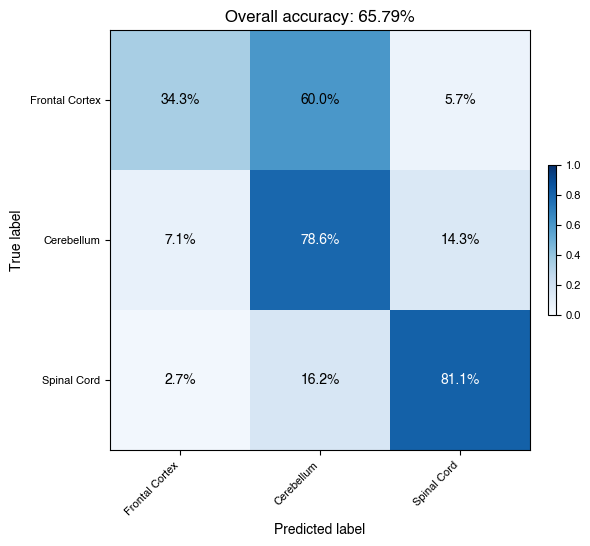

In [66]:

from sklearn.metrics import accuracy_score
model_name = 'RandomForest'   # ← change as desired
row = next(r for r in results if r['model'] == model_name)
y_pred = row['y_pred']
cm_full = confusion_matrix(y_test, y_pred)

# 3) Define your desired class order
new_order = ['Frontal Cortex', 'Cerebellum', 'Spinal Cord']
# Map those names back to the integer labels
order_idx = [list(le.classes_).index(c) for c in new_order]


cm = cm_full[np.ix_(order_idx, order_idx)]
cm_pct = cm / cm.sum(axis=1, keepdims=True)
overall_acc = accuracy_score(y_test, y_pred)
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm_pct, cmap='Blues', vmin=0, vmax=1)
cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, shrink = .3)
# cbar.set_label('Fraction of true class', rotation=270, labelpad=15)

# Tick labels in your new order
ax.set_xticks(np.arange(len(new_order)))
ax.set_yticks(np.arange(len(new_order)))
ax.set_xticklabels(new_order, rotation=45, ha='right')
ax.set_yticklabels(new_order)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Title with overall accuracy
ax.set_title(f'Overall accuracy: {overall_acc:.2%}')

# Annotate each cell with its percentage
for i in range(len(new_order)):
    for j in range(len(new_order)):
        fontcol = 'black' if cm_pct[i,j]<.7 else 'white'
        ax.text(
            j, i,
            f"{cm_pct[i, j]*100:.1f}%",
            ha='center', va='center', color=fontcol)

plt.tight_layout()
save_figure("confusions")
# plt.gcf().set_dpi(300)

